## Question 0: Salary Prediction

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import time

In [14]:
# read file
originalsalary = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/salary_uk.csv")
originalsalary

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
5,13179816,Engineering Systems Analyst Water Industry,Engineering Systems Analyst Water Industry Loc...,"Dorking, Surrey, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20K to 30K,25000,cv-library.co.uk
6,14131336,Senior Subsea Pipeline Integrity Engineer,A globally renowned engineering and training c...,"Aberdeen, Borders",UK,NaN,permanent,Indigo 21 Ltd,Engineering Jobs,50000 - 100000/annum,75000,cv-library.co.uk
7,14663196,RECRUITMENT CONSULTANT INDUSTRIAL / COMMERCIA...,THIS IS A LIVE VACANCY NOT A GENERIC ADVERTISE...,"MANCHESTER, Greater Manchester",Manchester,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,18000 - 26000/annum TO 26K BASIC + COMM + BENS,22000,cv-library.co.uk
8,14663197,RECRUITMENT CONSULTANT CONSTRUCTION / TECHNIC...,This is an exceptional opportunity to join a c...,"LEEDS, West Yorkshire",Leeds,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,18000 - 28000/annum 18 - 28K BASIC + COMM + BENS,23000,cv-library.co.uk
9,15395797,Subsea Cables Engineer,A subsea engineering company is looking for an...,"Aberdeen, UK",Aberdeen,NaN,permanent,Indigo 21 Ltd,Engineering Jobs,70000 - 100000/annum,85000,cv-library.co.uk


## Preliminary Visualization

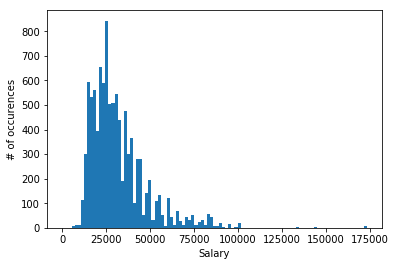

In [15]:
salary = originalsalary
plt.hist(originalsalary['SalaryNormalized'], bins=[n*1750 for n in range(100)], histtype='stepfilled')
plt.xlabel("Salary")
plt.ylabel("# of occurences")
plt.show()

## Data Preprocessing

In [16]:
# preprocessing

#get rid of useless columns
salary = salary.drop(['LocationRaw', 'SalaryRaw', 'SourceName'], axis=1)

#this loop does preprocessing on columns that are strings
for n in salary.columns:
    if salary[n].dtype == 'object':
        salary[n] = salary[n].str.lower()
        salary[n] = salary[n].str.strip()

#replace null values with the mode (most frequent occurence in the feature)
salary['Title'].fillna(value=salary['Title'].value_counts().axes[0][0], inplace=True)
salary['ContractType'].fillna(value=salary['ContractType'].value_counts().axes[0][0], inplace=True)
salary['ContractTime'].fillna(value=salary['ContractTime'].value_counts().axes[0][0], inplace=True)
salary['Company'].fillna(value=salary['Company'].value_counts().axes[0][0], inplace=True)
print (salary.shape)

(10000, 9)


In [17]:
#tf-idf
#first we create vector using only 1000 words and removing useless stop words
#we just consider words that matter to the target variable (salary)
vector = TfidfVectorizer(stop_words='english', max_features=1000)
titleVectorized = pd.DataFrame(vector.fit_transform(salary.Title).toarray(), columns = vector.get_feature_names())
descriptionVectorized = pd.DataFrame(vector.fit_transform(salary.FullDescription).toarray(), columns = vector.get_feature_names())
companyVectorized = pd.DataFrame(vector.fit_transform(salary.Company).toarray(), columns = vector.get_feature_names())
categoryVectorized = pd.DataFrame(vector.fit_transform(salary.Category).toarray(), columns = vector.get_feature_names())
#salary = salary.drop('FullDescription', axis=1)
#salary = pd.concat([salary.drop(['Title','FullDescription','Company','Category'], axis=1), titleVectorized,descriptionVectorized,companyVectorized,categoryVectorized], axis=1)
print (salary.shape)
print (salary.drop(['Title','FullDescription','Company','Category'], axis=1).shape)
print (titleVectorized.shape)
print (descriptionVectorized.shape)
print (companyVectorized.shape)
print (categoryVectorized.shape)

(10000, 9)
(10000, 5)
(10000, 1000)
(10000, 1000)
(10000, 1000)
(10000, 45)


In [18]:
#preprocess categorical features
#salary = pd.get_dummies(salary, columns=['Title', 'LocationNormalized', 'ContractTime', 'ContractType', 'Company', 'Category'], prefix=['Title', 'LocationNormalized', 'ContractTime', 'ContractType', 'Company', 'Category'])
salary = pd.get_dummies(salary, columns=['LocationNormalized', 'ContractTime', 'ContractType'], prefix=['LocationNormalized', 'ContractTime', 'ContractType'])
print (salary.shape)

(10000, 909)


## Training and Testing Models

In [19]:
#split dataset into training and testing 80% 20%
X = salary.drop('SalaryNormalized', axis=1)
Y = salary.SalaryNormalized
pca = PCA(n_components=1000)
pca.fit(X)
X = pca.transform(Y)
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, random_state=int(time.time()), test_size=0.20)

ValueError: could not convert string to float: 'healthcare & nursing jobs'

## Linear Regression

In [ ]:
lr = LinearRegression().fit(xTrain, yTrain)

#print("lr.coef_:", lr.coef_)
#print("lr.intercept_:", lr.intercept_)

print("Training set score: {:.2f}".format(lr.score(xTrain, yTrain)))
print("Test set score: {:.2f}".format(lr.score(xTest, yTest)))

## Ridge Regression

In [45]:
ridge = Ridge().fit(xTrain, yTrain)
print("Training set score: {:.2f}".format(ridge.score(xTrain, yTrain)))
print("Test set score: {:.2f}".format(ridge.score(xTest, yTest)))

NameError: name 'xTrain' is not defined

## Decision Trees

In [46]:
tree1 = DecisionTreeRegressor(max_depth=5).fit(xTrain, yTrain)
tree2 = DecisionTreeRegressor(max_depth=10).fit(xTrain, yTrain)
print ("Tree of depth 5 Training set score: {:.2f}".format(tree1.score(xTrain, yTrain)))
print ("Tree of depth 5 Test set score: {:.2f}".format(tree1.score(xTest, yTest)))
print ("Tree of depth 10 Training set score: {:.2f}".format(tree2.score(xTrain, yTrain)))
print ("Tree of depth 10 Test set score: {:.2f}".format(tree2.score(xTest, yTest)))
#higher depth means overfitting to the training data and lower accuracy on the testing data

NameError: name 'xTrain' is not defined

## K-Nearest Neighbors

In [47]:
for n in range(2,12):
    # this loop tries number of neighbors from 2 to 11
    knn = KNeighborsRegressor(n_neighbors=n)
    # KNN with 6 neighbors was found to be the most accurate in general
    knn.fit(xTrain, yTrain)
    print ("Training set score with " + str(n) + " neighbors: {:.2f}".format(knn.score(xTrain, yTrain)))
    print ("Test set score with " + str(n) + " neighbors: {:.2f}".format(knn.score(xTest, yTest)))

NameError: name 'xTrain' is not defined

## Gradient Boosted Regression

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(xTrain, yTrain)
print("Training set score: {:.3f}".format(gbr.score(xTrain, yTrain)))
print("Test set score: {:.3f}".format(gbr.score(xTest, yTest)))

## Conclusions

In [ ]:
Firs has beeen imported and data preprocessing has been done by getting rid of useless columns, nulls and strings then first we have created vector using only 1000 words and removing useless stop words and we just considered words that matter to the target variable (salary)